In [39]:
import pandas as pd

%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#importing libraries and printing wdir
import os
import pathlib as pth
import matplotlib.pyplot as plt
#from matplotlib import pyplot as plt, patches
import numpy as np
import importlib
import ipywidgets as ipw
import scipy.signal as si
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import dblquad
from scipy.optimize import differential_evolution
from scipy import interpolate
import time
from scipy.integrate import solve_ivp
from matplotlib.colors import LogNorm
#from numba import get_num_threads,set_num_threads,config,threading_layer
from numba import jit, config, set_num_threads, get_num_threads,threading_layer


print("Current Working Directory:", os.getcwd())
print("Files in Directory:", os.listdir())  # List all files and folders


# Load the XLS file
file_path = "g3c_input.xlsx"  # Update with your actual file path
df = pd.read_excel(file_path, engine="openpyxl",skiprows=1)  # Specify engine for old .xls format

# Display the first few rows
print(df.head())

# Accessing columns
for column in df.columns:
    print(f"Column: {column}")
    print(df[column].head())  # Print first few values in each column

import bimet_morelife_gen3c
importlib.reload(bimet_morelife_gen3c)


nm=1e-9

Current Working Directory: /home/matej/work/proj/morelife/bimet_fit
Files in Directory: ['bimet_morelife_gen3c.py', '.~lock.g3c_input.xlsx#', '.git', 'Untitled.ipynb', '.ipynb_checkpoints', 'g3c_input.xlsx', 'work', '__pycache__', 'importg3c.ipynb', 'PSD Analysis (JJ-0218).xlsx']
        GDL       MEM       MID     GDL.1     MEM.1     MID.1
0  4.750779  4.984424  4.517134  4.361371  4.984424  3.582555
1  4.049844  4.672897  2.803738  6.464174  5.373832  3.738318
2  3.971963  3.348910  3.971963  4.750779  4.906542  4.595016
3  4.205607  3.037383  4.127726  3.348910  3.971963  3.660436
4  4.361371  3.115265  3.348910  4.127726  4.672897  3.816199
Column: GDL
0    4.750779
1    4.049844
2    3.971963
3    4.205607
4    4.361371
Name: GDL, dtype: float64
Column: MEM
0    4.984424
1    4.672897
2    3.348910
3    3.037383
4    3.115265
Name: MEM, dtype: float64
Column: MID
0    4.517134
1    2.803738
2    3.971963
3    4.127726
4    3.348910
Name: MID, dtype: float64
Column: GDL.1
0    4.36

In [40]:

file_path = "g3c_input.xlsx"  # Update with your actual file path
df = pd.read_excel(file_path, engine="openpyxl",skiprows=1)  # Specify engine for old .xls format
data_array = df.to_numpy()
print(np.shape(data_array))


(4241, 6)


[1.250e-10 3.750e-10 6.250e-10 8.750e-10 1.125e-09 1.375e-09 1.625e-09
 1.875e-09 2.125e-09 2.375e-09 2.625e-09 2.875e-09 3.125e-09 3.375e-09
 3.625e-09 3.875e-09 4.125e-09 4.375e-09 4.625e-09 4.875e-09 5.125e-09
 5.375e-09 5.625e-09 5.875e-09 6.125e-09 6.375e-09 6.625e-09 6.875e-09
 7.125e-09 7.375e-09 7.625e-09]
[1.250e-10 3.750e-10 6.250e-10 8.750e-10 1.125e-09 1.375e-09 1.625e-09
 1.875e-09 2.125e-09 2.375e-09 2.625e-09]
[1.2500e-10 3.7500e-10 6.2500e-10 8.7500e-10 1.1250e-09 1.3750e-09
 1.6250e-09 1.8750e-09 2.1250e-09 2.3750e-09 2.6250e-09 2.8750e-09
 3.1250e-09 3.3750e-09 3.6250e-09 3.8750e-09 4.1250e-09 4.3750e-09
 4.6250e-09 4.8750e-09 5.1250e-09 5.3750e-09 5.6250e-09 5.8750e-09
 6.1250e-09 6.3750e-09 6.6250e-09 6.8750e-09 7.1250e-09 7.3750e-09
 7.6250e-09 7.8750e-09 8.1250e-09 8.3750e-09 8.6250e-09 8.8750e-09
 9.1250e-09 9.3750e-09 9.6250e-09 9.8750e-09 1.0125e-08]
31 11 41


/home/matej/miniconda3/envs/bimetal-numba/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Text(0, 0.5, 'Frequency')

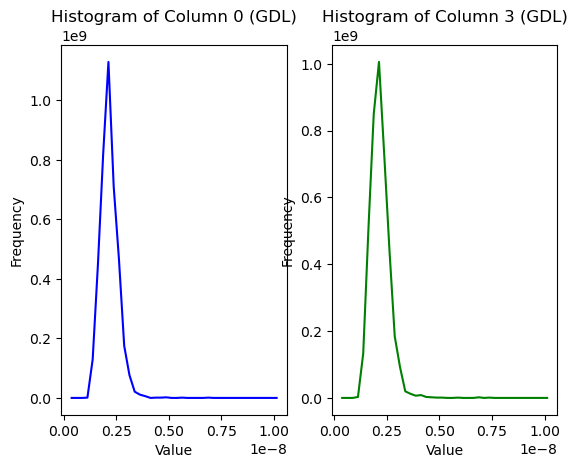

In [41]:
#problem: we have r data, dont have r bins 
#solution: select proper l, select proper c to discretize data.
#create r -> rebin. 
lmin=0.25
lmax=3
cmin=0.25
cmax=8


#return r vec from vec_l and vec_c
def f_vecr(vec_l,vec_c):    
    dc2 = (vec_c[1] - vec_c[0]) * 0.5
    dr2 = dc2
    vec_r= np.arange(dr2,vec_l[-1]+vec_c[-1],2*dr2)
    return vec_r


#return vector borders from vector mids.
#assuem equidist
def f_mids2bins(vec_mids):
    dr2=vec_mids[2]-vec_mids[1]
    vec_bins=np.zeros(len(vec_mids)+1)
    for i in range(len(vec_mids)):
        vec_bins[i+1]=dr2*i 
    return vec_bins


vec_c,vec_l=bimet_morelife_gen3c.f_vl_vc(lmin,lmax,cmin,cmax)
print(vec_c)
print(vec_l)
vec_r=f_vecr(vec_l,vec_c)

print(vec_r)

print(str(len(vec_c))+" "+str(len(vec_l))+" "+str(len(vec_r)))

bins_r = f_mids2bins(vec_r)

hist1 = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)
hist2 = np.histogram(nm*df.iloc[:, 1].dropna().to_numpy()*0.5,bins=bins_r,density=True)

#hist
#bins_r
nm*df.iloc[:, 0].dropna().to_numpy()*0.5

# Histogram for Column 0
plt.subplot(1, 2, 1)
plt.plot(vec_r,hist1[0],color="b")
#hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)
#plt.stem(hist[1][:-1],hist[0])
#plt.xlim([0.5*nm,7*nm])
plt.title(f"Histogram of Column 0 ({df.columns[0]})")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Histogram for Column 3
plt.subplot(1, 2, 2)
plt.plot(vec_r,hist2[0],color="g")

#plt.hist(selected_columns.iloc[:, 1].dropna()*0.5, bins=25, color='green')
plt.title(f"Histogram of Column 3 ({df.columns[0]})")
plt.xlabel("Value")
plt.ylabel("Frequency")


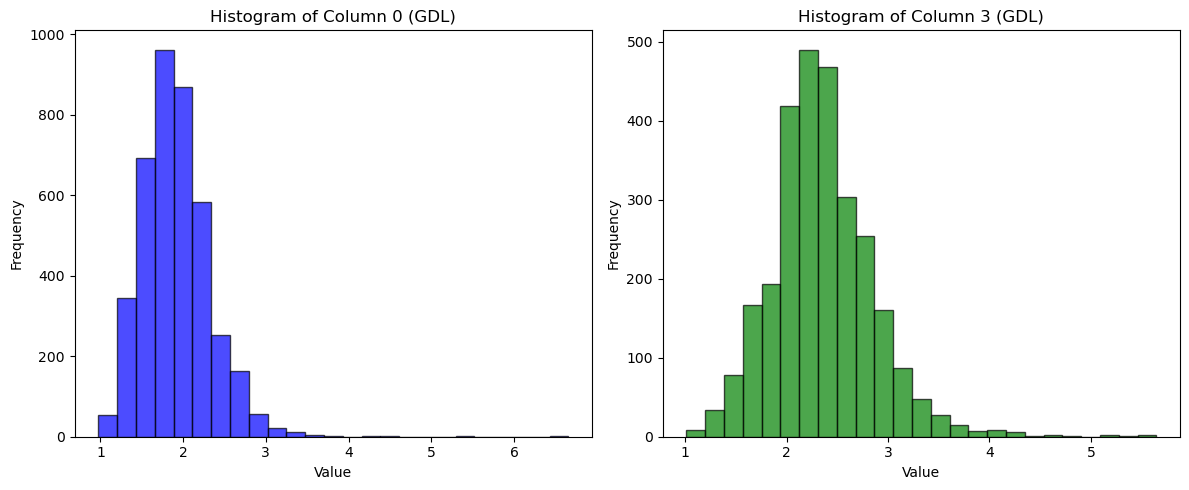

In [42]:
selected_columns = df.iloc[:, [0, 3]]  # Select first and fourth columns

# Plot histograms
plt.figure(figsize=(12, 5))

# Histogram for Column 0
plt.subplot(1, 2, 1)
plt.hist(selected_columns.iloc[:, 0].dropna()*0.5, bins=25, color='blue', edgecolor='black', alpha=0.7)
#hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)
#plt.stem(hist[1][:-1],hist[0])
#plt.xlim([0.5*nm,7*nm])
plt.title(f"Histogram of Column 0 ({df.columns[0]})")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Histogram for Column 3
plt.subplot(1, 2, 2)
plt.hist(selected_columns.iloc[:, 1].dropna()*0.5, bins=25, color='green', edgecolor='black', alpha=0.7)
plt.title(f"Histogram of Column 3 ({df.columns[0]})")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [43]:
#data succesfully imported
#now describe starting distribution
FCstate=bimet_morelife_gen3c.FCstate
ModPars0=np.copy(bimet_morelife_gen3c.ModPars)
vek_in=[6.420e-01,2.699e-01,2.000e-01,1.148e+00]
#n=7 starting synthetic ratio.
#end mass ratio. 28/1.8
#translate to atomic ratio
#assume there is core and shell structure
#assume some distribution in shell #uniform relatively sharp with free parameter POSITON 
#adjust core distriburtion parameters to fit the final distribution and final pt/cu ratio
#finaly normalise to pt data

#n=7 starting synthetic ratio. Fixed in librarz CHECK
#end mass ratio. 28/1.8 TODO CHECK
Pt_Cu_rat=25.8/0.8
print(f"Mass Ratio (Pt:Cu) = {Pt_Cu_rat:.4f}")

#translate to atomic ratio
def mass_to_atomic_ratio(mass_ratio_pt_to_cu):
    # Atomic masses of Pt and Cu
    atomic_mass_pt = 195.08  # g/mol
    atomic_mass_cu = 63.55   # g/mol

    # Convert mass ratio to atomic ratio
    atomic_ratio = mass_ratio_pt_to_cu * (atomic_mass_cu / atomic_mass_pt)
    
    return atomic_ratio

# Example: If mass ratio (Pt:Cu) is 2:1 (meaning 2g Pt for 1g Cu)
#mass_ratio = 2  # Adjust based on your input
atomic_ratio = mass_to_atomic_ratio(Pt_Cu_rat)

print(f"Atomic Ratio (Pt:Cu) = {atomic_ratio:.4f}")

#assume there is core and shell structure
#assume some distribution in shell #uniform relatively sharp with free parameter POSITON
#adjust core distriburtion parameters to fit the final distribution and final pt/cu ratio
bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=5,cmin=0.25,cmax=10,MPars=ModPars0, loc_l=0.25, scale_l=0.25, s_c=0.7, loc_c=0.4, scale_c=2)
#finaly normalise to pt data 
Pt_load=0.15 #mg/cm2

Mass Ratio (Pt:Cu) = 32.2500
Atomic Ratio (Pt:Cu) = 10.5059


23
19
41
41
[9.94035785e+04 9.94035785e+04 9.94035785e+04 9.94035785e+05
 1.29224652e+08 4.48310139e+08 8.20079523e+08 1.12922465e+09
 7.10735586e+08 4.66202783e+08 1.74950298e+08 7.65407555e+07
 2.08747515e+07 1.09343936e+07 5.96421471e+06 9.94035785e+04
 9.94035785e+05 9.94035785e+05 1.98807157e+06 9.94035785e+04
 9.94035785e+04 9.94035785e+05 9.94035785e+04 9.94035785e+04
 9.94035785e+04 9.94035785e+04 9.94035785e+05 9.94035785e+04
 9.94035785e+04 9.94035785e+04 9.94035785e+04 9.94035785e+04
 9.94035785e+04 9.94035785e+04 9.94035785e+04 9.94035785e+04
 9.94035785e+04 9.94035785e+04 9.94035785e+04 9.94035785e+04
 9.94035785e+04]
10.9575407936796
10.505882202173467


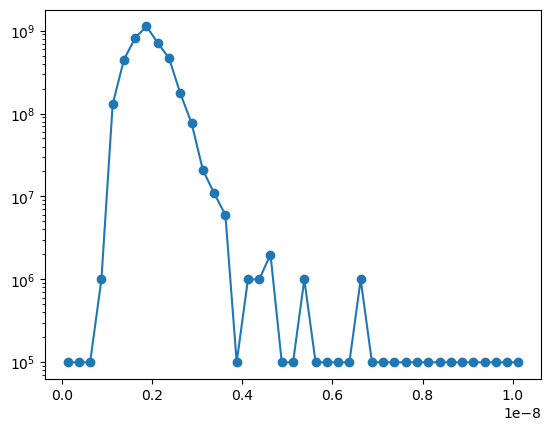

In [44]:

def f_norm_max(vek):
    Max=max(vek)
    return vek/Max
#plot starting dist normed to r, as well as Pt,Cu ratio. Should be more than 3. since some of cu is lost
FCstate=bimet_morelife_gen3c.FCstate
ModPars0=np.copy(bimet_morelife_gen3c.ModPars)
vek_in=[6.420e-01,2.699e-01,2.000e-01,1.148e+00]
vek_in=[ 6.575e-01 , 2.699e-01 , 1.003e-02 , 1.325e+00]
vek_in=[ 6.573e-01 , 2.698e-01 , 1.105e-02 , 1.324e+00]
dist_bins_om ,vec_c, vec_l=bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=5,cmin=0.25,cmax=6,MPars=ModPars0, loc_l=vek_in[0], scale_l=0.25, s_c=vek_in[1], loc_c=vek_in[2], scale_c=vek_in[3])
#dist_bins_om ,vec_c, vec_l=bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=5,cmin=0.25,cmax=6,MPars=ModPars, loc_l=0.25, scale_l=0.25, s_c=0.7, loc_c=0.4, scale_c=2)
pars=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])

#make dr
dc2 = (vec_c[1] - vec_c[0]) * 0.5
#does it have to be that way? would it work with any dr?
dr2 = dc2
#dr vector
vec_r= np.arange(dr2,vec_l[-1]+vec_c[-1],2*dr2)

print(len(vec_c))
print(len(vec_l))
print(len(vec_r))

nSt = 3
#number of bins
nc = len(vec_c)
nl = len(vec_l)
# total number of variables
nSys = nSt+nc*nl

### set initial distribution
#initial states
X0 = np.zeros(nSys)
# cathode
#fill the bins starting vector
X0[0]=1.0*10**-10
X0[1]=1.0*10**-2
X0[2]=1.0*10**-10
X0[3:]=dist_bins_om.flatten()

#solve a run
#sol0 = solve_ivp(f_dfdt, (ti[0],ti[-1]), X0, method='LSODA',events=stop_condition, t_eval=ti, args=pars, rtol  = tol_r, atol = tol_a)
#sol0 = solve_ivp(f_dfdt, (ti[0],ti[-1]), X0, method='LSODA',events=None, t_eval=ti, args=pars, rtol  = tol_r, atol = tol_a)

#get X from the solution
#X=sol0.y[:,-1]

#transform to r distribution
#res,vec_r=f_cl_to_rl_rc(X,nSt,vec_l,vec_c)
om=bimet_morelife_gen3c.f_X_to_dist(X0,vec_l,vec_c)
r=bimet_morelife_gen3c.f_om_to_r(om)
print(len(r))
#norm end r dist
rez_norm_r = bimet_morelife_gen3c.f_norm_dist1d(vec_r,r)

#calculate the price function
#d2_n calculated before, its a hardcoded input for all evolution calls
#price = f_sum_abs(d2_n,rez_norm_r,vec_r)

bins_r=np.insert(vec_r+vec_r[0],0,0)
hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)



#plt.plot(vec_r,f_norm_max(rez_norm_r))
#plt.plot(vec_r,hist[0],marker="o")

plt.plot(vec_r,hist_fix,marker="o")

#plt.plot(vec_r,f_norm_max((vec_r**3*abs(rez_norm_r-hist[0]))),marker="o")
"""
hist = np.histogram(nm*df.iloc[:, 3].dropna().to_numpy()*0.5,bins=bins_r,density=True)
plt.plot(vec_r,rez_norm_r)
plt.plot(vec_r,hist[0],marker="o")
"""
plt.yscale('log')
#plt.ylim([1e4,2e9])

X=bimet_morelife_gen3c.f_dist_to_X(dist_bins_om)
#calc pt_cu as well give it half the weight
rez_stats = bimet_morelife_gen3c.f_stats(X,ModPars0,vec_c,vec_l)
pt_cu=rez_stats[-2]/rez_stats[-1]

print(pt_cu)
print(atomic_ratio)

3 9.000000000000023
16 68.00000000000023
17 9.000000000000034
18 0.9999999999999932
19 28.99999999999996
20 18.999999999999996
21 9.000000000000034
22 18.000000000000068
23 9.000000000000034
26 8.999999999999998
27 17.999999999999996
28 8.999999999999998
207.00000000000034
[9.94035785e+04 9.94035785e+04 9.94035785e+04 9.94035785e+05
 1.29224652e+08 4.48310139e+08 8.20079523e+08 1.12922465e+09
 7.10735586e+08 4.66202783e+08 1.74950298e+08 7.65407555e+07
 2.08747515e+07 1.09343936e+07 5.96421471e+06 9.94035785e+04
 9.94035785e+05 9.94035785e+05 1.98807157e+06 9.94035785e+04
 9.94035785e+04 9.94035785e+05 9.94035785e+04 9.94035785e+04
 9.94035785e+04 9.94035785e+04 9.94035785e+05 9.94035785e+04
 9.94035785e+04 9.94035785e+04 9.94035785e+04 9.94035785e+04
 9.94035785e+04 9.94035785e+04 9.94035785e+04 9.94035785e+04
 9.94035785e+04 9.94035785e+04 9.94035785e+04 9.94035785e+04
 9.94035785e+04]


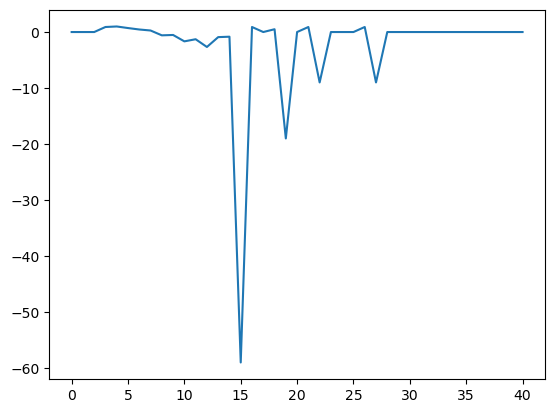

In [46]:
h1=np.diff(hist_fix)
h2=np.diff(h1)
h3=np.diff(h2)


#plt.plot(h1)
plt.plot(np.pad(h1, (1,0 ), mode='constant', constant_values=0)/hist_fix)
#plt.plot(h3)

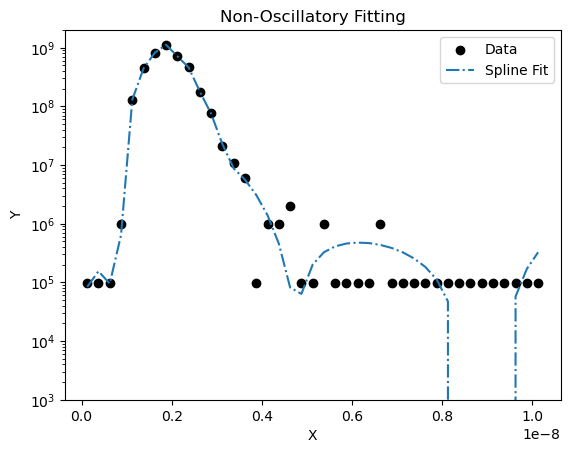

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

# Load your data (replace with your actual data)
# Example: x = np.array([...]), y = np.array([...])
y = hist_fix
x = vec_r

lambda_penalty = 15e13 # Adjust to control smoothness
spline = UnivariateSpline(x, y, s=lambda_penalty)
y_spline = spline(x)
#y_spline_fit = spline(x_fit)

# Plot results
plt.scatter(x, y, label="Data", color='black')
#plt.plot(x_fit, y_exp_fit, label="Exponential Fit", linestyle='dashed')
#plt.plot(x_fit, y_poly_fit, label="Polynomial Fit", linestyle='dotted')
plt.plot(x, y_spline, label="Spline Fit", linestyle='dashdot')
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.yscale('log')
plt.ylim([1e3,2e9])

plt.title("Non-Oscillatory Fitting")
plt.show()


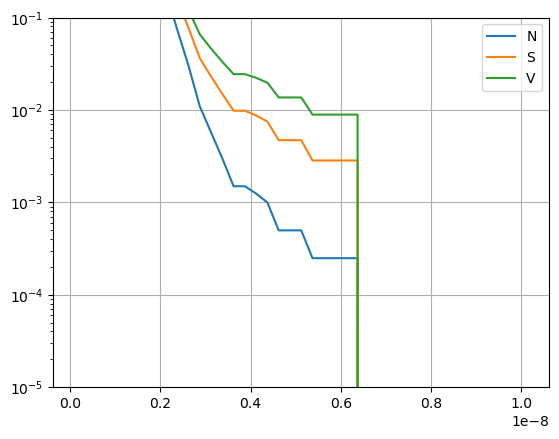

In [48]:

cN=np.cumsum(hist[0])
cN=cN/cN[-1]

cS=np.cumsum(hist[0]*vec_r*vec_r)
cS=cS/cS[-1]

cV=np.cumsum(hist[0]*vec_r*vec_r*vec_r)
cV=cV/cV[-1]

plt.plot(vec_r,1.-cN,label="N")
plt.plot(vec_r,1.-cS,label="S")
plt.plot(vec_r,1.-cV,label="V")

plt.yscale('log')
plt.ylim([1e-5,1e-1])

plt.legend()
plt.grid()
#cumulative surface and volume
#cumulative pt and cu 

3 99.00000000000024
16 698.0000000000024
17 99.00000000000034
18 0.9999999999999932
19 298.99999999999966
20 199.0
21 99.00000000000034
22 198.00000000000068
23 99.00000000000034
26 99.0
27 198.0
28 99.0
1.1230240203720951
3.845551686628441
15.378540211339145
2187.000000000004


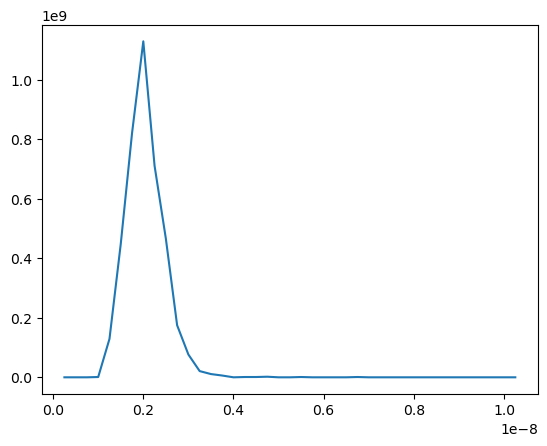

In [56]:
#do fast optimisation dif evo price function
dist_bins_om ,vec_c, vec_l=bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=3,cmin=0.25,cmax=8,MPars=ModPars0, loc_l=vek_in[0], scale_l=0.25*0.5, s_c=vek_in[1], loc_c=vek_in[2], scale_c=vek_in[3])
dc2 = (vec_c[1] - vec_c[0]) * 0.5
dr2 = dc2
vec_r= np.arange(dr2,vec_l[-1]+vec_c[-1],2*dr2)
hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)

ModPars= np.copy(bimet_morelife_gen3c.ModPars)

dist_bins_om ,vec_c, vec_l = bimet_morelife_gen3c.f_start_dist_cin(hist[0],lmin1=0.25,lmax1=5.,cmin1=0.25,MPars=ModPars, loc_l=0.25, scale_l=0.25)

#fix a distribution by using miniumm values instead of 
def f_fix_dist(datain):
    data=np.copy(datain)
    factor=1e-2
    dmax=max(data)
    dmin=min(data[data != 0])
    
    for i,d in enumerate(datain):
        if d<dmin*factor:
            data[i]=dmin*factor

    return data
    
#create a smoothing contraint in order to fit data.
#check 3 neghbours if derivative changes sign, and not maximum provide penaltzy
def f_penal(vec):
    #loop trough 
    penals=0
    max_index = np.argmax(vec) #aha find th eabsolute maimum!
    for i,val in enumerate(vec[2:]):
        if i-1 != max_index:
            rez=np.diff([vec[i-2],vec[i-1],vec[i]])/np.min([vec[i-2],vec[i-1],vec[i]])
            if np.sign(rez[0]) != np.sign(rez[1]):
                penal = np.sum(np.abs(rez))
                print(str(i)+" "+str(penal))
                penals +=penal
    return penals

#alternative implementation of fiting
#start by offsetting 
def f_price_direct(vek_in):

    #make it anyway. easier to work with.
    dist_bins_om ,vec_c, vec_l = bimet_morelife_gen3c.f_start_dist_cin(vek_in[1:],lmin1=0.25,lmax1=5.,cmin1=0.25,MPars=ModPars, loc_l=vek_in[0], scale_l=0.25*0.5)
    #dist_bins_om ,vec_c, vec_l = bimet_morelife_gen3c.f_start_dist_cin(vek_in[1:],lmin1=0.25,lmax1=5.,cmin1=0.25,MPars=ModPars, loc_l=vek_in[0], scale_l=0.25*0.5)
    pars=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])

    #print(vec_l)
    #print(vec_c)
    
    dc2 = (vec_c[1] - vec_c[0]) * 0.5
    dr2 = dc2
    vec_r= np.arange(dr2,vec_l[-1]+vec_c[-1],2*dr2)

    """
    print(len(vek_in[1:]))
    print(len(hist[0]))
    print(len(vec_l))
    print(len(vec_c))
    print(len(vec_r))
    """

    r=bimet_morelife_gen3c.f_om_to_r(dist_bins_om)
    rez_norm_r = bimet_morelife_gen3c.f_norm_dist1d(vec_r,r)

    bins_r=np.insert(vec_r+vec_r[0],0,0)
    #hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)
    priceN = bimet_morelife_gen3c.f_sum_abs( hist[0],rez_norm_r,vec_r)
    priceS = bimet_morelife_gen3c.f_sum_abs( hist[0]*vec_r*vec_r/(nm**2),rez_norm_r*vec_r*vec_r/(nm*2),vec_r)
    priceV = bimet_morelife_gen3c.f_sum_abs( hist[0]*vec_r*vec_r*vec_r/(nm**3),rez_norm_r*vec_r*vec_r*vec_r/(nm**3),vec_r)

    priceDer=f_penal(vek_in[1:])
    
    print(priceN)
    print(priceS)
    print(priceV)
    print(priceDer)

    
    X=bimet_morelife_gen3c.f_dist_to_X(dist_bins_om)
    #calc pt_cu as well give it half the weight
    rez_stats = bimet_morelife_gen3c.f_stats(X,ModPars0,vec_c,vec_l)
    pt_cu=rez_stats[-2]/rez_stats[-1]
    #print(pt_cu)
    #print(rez_stats[-1])

    pt_price=abs(pt_cu-atomic_ratio)
    #print(pt_price)
    
    price=priceS+priceV+pt_price
    #price=priceN+pt_price

    
    #print(rez_stats)

    #interpolate to r values
    """
    fig=plt.figure(figsize=(14, 8))
    ax11 = fig.add_subplot(1,1,1)
    ax=ax11
    im = ax.imshow(dist_bins_om,extent =[vec_c[0], vec_c[-1], vec_l[0], vec_l[-1]], interpolation ='none',origin='lower')
    fig.colorbar(im, ax=ax)
    ax.set_title("doist BOE")
    """
    return price

def f_price(vek_in):
    
    dist_bins_om ,vec_c, vec_l=bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=3,cmin=0.25,cmax=8,MPars=ModPars0, loc_l=vek_in[0], scale_l=0.25*0.5, s_c=vek_in[1], loc_c=vek_in[2], scale_c=vek_in[3])
    pars=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])

    #dist_bins_om = np.zeros((np.shape(dist_bins_om)))
    #dist_bins_om[5,10]=1e30
    
    r=bimet_morelife_gen3c.f_om_to_r(dist_bins_om)
    rez_norm_r = bimet_morelife_gen3c.f_norm_dist1d(vec_r,r)

    bins_r=np.insert(vec_r+vec_r[0],0,0)
    #hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)
    priceN = bimet_morelife_gen3c.f_sum_abs( hist[0],rez_norm_r,vec_r)
    priceS = bimet_morelife_gen3c.f_sum_abs( hist[0]*vec_r*vec_r/(nm**2),rez_norm_r*vec_r*vec_r/(nm*2),vec_r)
    priceV = bimet_morelife_gen3c.f_sum_abs( hist[0]*vec_r*vec_r*vec_r/(nm**3),rez_norm_r*vec_r*vec_r*vec_r/(nm**3),vec_r)
    
    print(priceN)
    print(priceS)
    print(priceV)

    X=bimet_morelife_gen3c.f_dist_to_X(dist_bins_om)
    #calc pt_cu as well give it half the weight
    rez_stats = bimet_morelife_gen3c.f_stats(X,ModPars0,vec_c,vec_l)
    pt_cu=rez_stats[-2]/rez_stats[-1]
    #print(pt_cu)
    #print(rez_stats[-1])

    pt_price=abs(pt_cu-atomic_ratio)
    #print(pt_price)
    
    price=priceS+priceV+pt_price
    #price=priceN+pt_price

    
    #print(rez_stats)

    #interpolate to r values
    """
    fig=plt.figure(figsize=(14, 8))
    ax11 = fig.add_subplot(1,1,1)
    ax=ax11
    im = ax.imshow(dist_bins_om,extent =[vec_c[0], vec_c[-1], vec_l[0], vec_l[-1]], interpolation ='none',origin='lower')
    fig.colorbar(im, ax=ax)
    ax.set_title("doist BOE")
    """
    return price

#[5e-01,2.699e-01,2.000e-01,1.148e+00]
#vek_in=[ 6.420e-01,  2.699e-01,  2.000e-01,  1.148e+00]
#=[ 0.5, 8e-01,  15.000e-01,  1.148e+00]
#vek_0=[ 6.575e-01 , 2.699e-01 , 1.003e-02 , 1.325e+00]
#print(f_price(vek_in))

def f_callback(xk, convergence):
    price=f_price(xk)
    print(f"Current solution: {xk}, Convergence: {convergence}")


hist_fix=f_fix_dist(hist[0])

dist_bins_om ,vec_c, vec_l = bimet_morelife_gen3c.f_start_dist_cin(hist_fix,lmin1=0.25,lmax1=5.,cmin1=0.25,MPars=ModPars, loc_l=0.25*3, scale_l=0.25*0.5)

vek_in = np.append([0.25*3],hist_fix)
    
f_price_direct(vek_in)
plt.plot(hist[1][1:],hist[0])
#plt.yscale("log")
#plt.ylim([1e3,2e9])
#plt.imshow(dist_bins_om)

#print(f_penal(hist_fix))
#print(hist_fix)


In [58]:
bounds=[(0.4,0.7)]

for i,r in enumerate(hist_fix):
    bounds.append((0,hist_fix+3e6))

vek_0=np.append([5e-01],hist_fix)

print(bounds)
print(vek_0)

print(len(bounds))
print(len(vek_0))
#vek_0=[ 6.575e-01 , 2.699e-01 , 1.003e-02 , 1.325e+00]
rezultat = differential_evolution(f_price, bounds=bounds,x0=vek_0,polish=True,popsize=100, maxiter=200, callback=f_callback, tol=0.0001, disp = True,updating="deferred",workers=-1)


[(0.4, 0.7), (0, array([3.00994036e+06, 3.00994036e+06, 3.00994036e+06, 3.99403579e+06,
       1.32224652e+08, 4.51310139e+08, 8.23079523e+08, 1.13222465e+09,
       7.13735586e+08, 4.69202783e+08, 1.77950298e+08, 7.95407555e+07,
       2.38747515e+07, 1.39343936e+07, 8.96421471e+06, 3.00994036e+06,
       3.99403579e+06, 3.99403579e+06, 4.98807157e+06, 3.00994036e+06,
       3.00994036e+06, 3.99403579e+06, 3.00994036e+06, 3.00994036e+06,
       3.00994036e+06, 3.00994036e+06, 3.99403579e+06, 3.00994036e+06,
       3.00994036e+06, 3.00994036e+06, 3.00994036e+06, 3.00994036e+06,
       3.00994036e+06, 3.00994036e+06, 3.00994036e+06, 3.00994036e+06,
       3.00994036e+06, 3.00994036e+06, 3.00994036e+06, 3.00994036e+06,
       3.00994036e+06])), (0, array([3.00994036e+06, 3.00994036e+06, 3.00994036e+06, 3.99403579e+06,
       1.32224652e+08, 4.51310139e+08, 8.23079523e+08, 1.13222465e+09,
       7.13735586e+08, 4.69202783e+08, 1.77950298e+08, 7.95407555e+07,
       2.38747515e+07, 1.39343

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (42, 2) + inhomogeneous part.

In [261]:
bounds=[(0.4,0.7),(0.01,2),(0.01,1),(0.1,3)]
vek_0=[5e-01,2.699e-01,2.000e-01,1.148e+00]
#vek_0=[ 6.575e-01 , 2.699e-01 , 1.003e-02 , 1.325e+00]
rezultat = differential_evolution(f_price_direct, bounds=bounds,x0=vek_0,polish=True,popsize=100, maxiter=200, callback=f_callback, tol=0.0001, disp = True,updating="deferred",workers=-1)


RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

In [8]:
rezultat

NameError: name 'rezultat' is not defined

In [11]:
#check 
vek_in=[ 6.573e-01 , 2.698e-01 , 1.105e-02 , 1.324e+00]
print(f_price(vek_in))


4.7957137744757565


In [36]:
#na roke preveri razmerje pt cu:

#V=4pir3/3
def f_vol(r):
    V=4*np.pi*r**3/3.
    return V

c=2
l=0.6

def f_cor_shell(l,c):
    V_cor   = f_vol(c)
    V_shell = f_vol(c+l)-f_vol(c)
    return V_cor,V_shell

def f_pt_cu(V_cor,V_shell,n=3.,sig_al=1.,sig_pt=1.):
    Cu=(1./(n+1.))*V_cor*sig_al
    Pt=(n/(n+1.))*V_cor*sig_al
    Pt=Pt+V_shell*sig_pt
    return Pt,Cu

V_cor,V_shell=f_cor_shell(l,c)
Pt,Cu=f_pt_cu(V_cor,V_shell)

print(V_cor,V_shell)
print(Pt/Cu)

#conclusion: assuming we have a sharp population of particles around 2nm in core radius we need incredibly 

33.510321638291124 40.11185500103449
7.788000000000001


Text(0.5, 1.0, 'doist BOE')

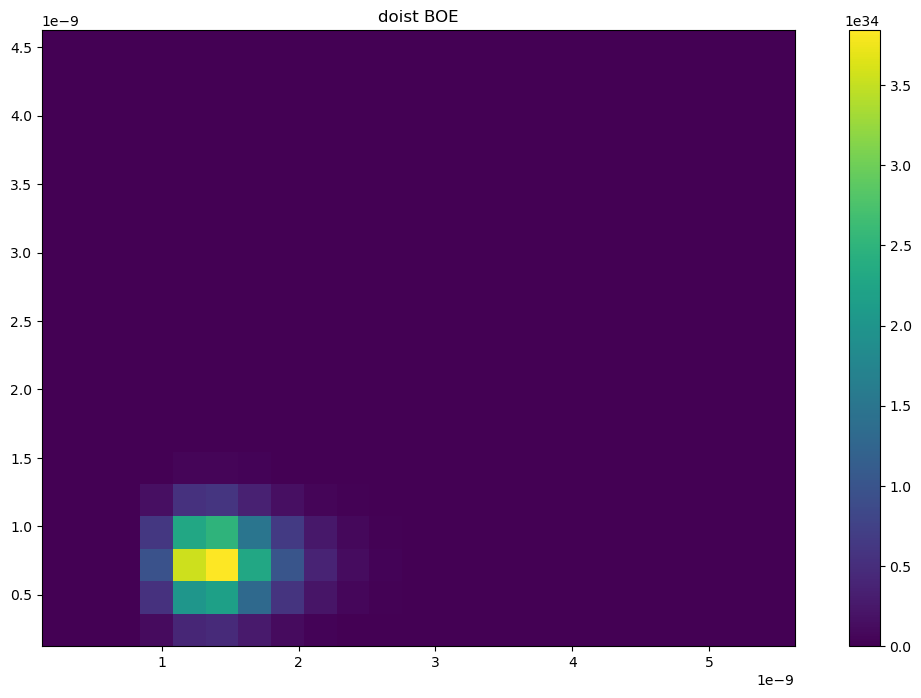

In [20]:
#interpolate to r values
fig=plt.figure(figsize=(14, 8))
ax11 = fig.add_subplot(1,1,1)
ax=ax11
im = ax.imshow(om,extent =[vec_c[0], vec_c[-1], vec_l[0], vec_l[-1]], interpolation ='none',origin='lower')
#im = ax.imshow(om,extent =[vec_c[0], vec_c[-1], vec_l[0], vec_l[-1]], interpolation ='none',origin='lower',norm=LogNorm(vmin=1e26, vmax=1e30))
fig.colorbar(im, ax=ax)
ax.set_title("doist BOE")



In [22]:
rezultat

 message: Optimization terminated successfully.
 success: True
     fun: 10.085678493222439
       x: [ 1.797e+00  2.816e+00  7.068e-01  4.051e+00]
     nit: 1
    nfev: 805

In [ ]:
#easily calculate pt/cu ratio.